<a href="https://colab.research.google.com/github/ni-metre/Colab_Triplet_Loss_Backup/blob/master/Check_Fake_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#Set up gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [22]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
#To remoount drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [23]:
# Load the Pandas libraries with alias 'pd' 
import sys
import os
import os.path
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt


import datetime as datetime
import math
import random
% xmode verbose

Exception reporting mode: Verbose


In [24]:
fakes_descriptor = 'med_Ac'
fakes_path = '/content/drive/My Drive/Minimal_Fakes_19_' + fakes_descriptor + '/'

In [25]:
global fake_test_db_df
fake_test_db_df = pd.read_csv('/content/drive/My Drive/Fake_Test_Log_for_Minimal_ML_med_Ac.csv')
for col in fake_test_db_df.columns:
  if col not in ['Raw_data', 'Test_name', 'Other', 'Date', 'Time', 'Flag', 'Notes']:
    fake_test_db_df[col] = pd.to_numeric(fake_test_db_df[col])
    fake_test_db_df[col] = fake_test_db_df[col].fillna(0)
fake_test_db_df.set_index('File', inplace = True)
fake_test_db_df.head()

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old,Tests,File_num
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9600,pdata9600,4% CO2 through plain water,10.0,40000.0,0.4,0.0000,0.0,0.0,1.0,19.0,2020-08-12,4:52:10,100000.0,1.0,40.21,0.0,26.97,26.70,4.29,0.0,NaN,250.0,29739.0,138.590360,140.299732,1.7094,-201.494212,2.564,641.0,9.720,2430.0,21.255789,15.180,3795.0,0.0,0.0,-964.480165,0.0,0.0,531.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9600.0,0.0
9603,pdata9603,4% CO2 through plain water,10.0,40000.0,0.8,0.0000,0.0,0.0,1.0,19.0,2020-08-12,5:02:22,612.0,2.0,41.68,0.0,26.38,26.17,4.38,0.0,NaN,250.0,29762.0,138.598053,139.051119,0.4531,-214.762738,2.588,647.0,9.784,2446.0,22.320042,15.192,3798.0,0.0,0.0,-1031.707572,0.0,0.0,553.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9603.0,0.0
9606,pdata9606,6% CO2 through plain water,10.0,60000.0,1.4,0.0000,0.0,0.0,1.0,19.0,2020-08-12,5:11:17,535.0,3.0,43.80,0.0,25.74,25.51,4.29,0.0,NaN,250.0,29775.0,138.543365,139.034170,0.4908,-319.336814,2.584,646.0,9.896,2474.0,32.715501,15.228,3807.0,0.0,0.0,-1551.996551,0.0,0.0,863.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9606.0,0.0
9609,pdata9609,6% CO2 through plain water,10.0,60000.0,2.0,0.0000,0.0,0.0,1.0,19.0,2020-08-12,5:20:20,543.0,4.0,43.88,0.0,25.39,25.10,4.24,0.0,NaN,250.0,29766.0,138.240113,138.832362,0.5922,-321.963345,2.616,654.0,9.956,2489.0,33.050086,15.388,3847.0,0.0,0.0,-1574.392437,0.0,0.0,854.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9609.0,0.0
9612,pdata9612,4% CO2 through 1.5625 ppm acetone simulator,10.0,40000.0,2.4,1.5625,0.0,0.0,1.0,19.0,2020-08-12,5:52:40,1940.0,5.0,40.49,0.0,26.04,25.87,4.27,0.0,NaN,250.0,29744.0,138.525839,138.691733,0.1659,-175.652029,2.588,647.0,9.692,2423.0,19.664613,15.152,3788.0,0.0,0.0,-843.821572,0.0,0.0,436.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9612.0,0.0


In [12]:
fake_test_db_df.head(-1)

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old,Tests,File_num
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9600,pdata9600,4% CO2 through plain water,10.0,40000.0,0.400000,0.0000,0.0,0.0,1.0,19.0,2020-08-12,4:52:10,100000.0,1.000000,40.21,0.0,26.970000,26.70,4.29,0.0,NaN,250.0,29739.0,138.590360,140.299732,1.7094,-201.494212,2.564,641.0,9.720,2430.0,21.255789,15.180,3795.0,0.0,0.0,-964.480165,0.0,0.0,531.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9600.0,0.0
9603,pdata9603,4% CO2 through plain water,10.0,40000.0,0.800000,0.0000,0.0,0.0,1.0,19.0,2020-08-12,5:02:22,612.0,2.000000,41.68,0.0,26.380000,26.17,4.38,0.0,NaN,250.0,29762.0,138.598053,139.051119,0.4531,-214.762738,2.588,647.0,9.784,2446.0,22.320042,15.192,3798.0,0.0,0.0,-1031.707572,0.0,0.0,553.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9603.0,0.0
9606,pdata9606,6% CO2 through plain water,10.0,60000.0,1.400000,0.0000,0.0,0.0,1.0,19.0,2020-08-12,5:11:17,535.0,3.000000,43.80,0.0,25.740000,25.51,4.29,0.0,NaN,250.0,29775.0,138.543365,139.034170,0.4908,-319.336814,2.584,646.0,9.896,2474.0,32.715501,15.228,3807.0,0.0,0.0,-1551.996551,0.0,0.0,863.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9606.0,0.0
9609,pdata9609,6% CO2 through plain water,10.0,60000.0,2.000000,0.0000,0.0,0.0,1.0,19.0,2020-08-12,5:20:20,543.0,4.000000,43.88,0.0,25.390000,25.10,4.24,0.0,NaN,250.0,29766.0,138.240113,138.832362,0.5922,-321.963345,2.616,654.0,9.956,2489.0,33.050086,15.388,3847.0,0.0,0.0,-1574.392437,0.0,0.0,854.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9609.0,0.0
9612,pdata9612,4% CO2 through 1.5625 ppm acetone simulator,10.0,40000.0,2.400000,1.5625,0.0,0.0,1.0,19.0,2020-08-12,5:52:40,1940.0,5.000000,40.49,0.0,26.040000,25.87,4.27,0.0,NaN,250.0,29744.0,138.525839,138.691733,0.1659,-175.652029,2.588,647.0,9.692,2423.0,19.664613,15.152,3788.0,0.0,0.0,-843.821572,0.0,0.0,436.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9612.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38246,NaN,Combo of 9741 and 9813 | Weight - 0.7931034482...,10.0,60000.0,33.517241,25.0000,0.0,NaN,1.0,19.0,NaN,NaN,540.0,67.034483,0.00,0.0,30.970690,0.00,0.00,0.0,NaN,250.0,29767.0,142.465153,143.475822,0.0000,-587.124094,2.304,576.0,8.088,2022.0,111.711646,13.520,3380.0,0.0,0.0,-2521.000000,0.0,0.0,3320.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [31]:
def get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])
    #return(filtered)
def make_db_from_get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    new_df = filtered.loc[filtered.index > Range1]
    new_df = new_df.loc[new_df.index < Range2]
    #return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])
    return(new_df)

In [6]:
def get_test_temp_list (df, Acetone, ac_delta, CO2, H2O, temp, t_delta, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered[filtered['Acetone']>= Acetone - ac_delta]
                filtered = filtered[filtered['Acetone']<= Acetone + ac_delta]
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')


    filtered = filtered[filtered['Instr_Temp']>= temp - t_delta]
    filtered = filtered[filtered['Instr_Temp']<= temp + t_delta]
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])


# Compare Fake tests to similar real data tests

In [7]:
test_list = get_test_temp_list(fake_test_db_df, 0, 1 , 5, 10, 25, 1, 19, 10000,100000)
print(len(test_list))
test_list = get_test_temp_list(fake_test_db_df, 10, 1 , 5, 10, 25, 0.5, 19, 10000,100000)
print(len(test_list))
test_list = get_test_temp_list(fake_test_db_df, 12.5, 0.5 , 4, 10, 26, 0.2, 19,10000,100000)
print(len(test_list))
#test_list = get_test_temp_list(fake_test_db_df, 20, 1 , 5, 10, 25, 0.5, 19, 10000,100000)
#print(len(test_list))
real_test_list = get_test_temp_list(fake_test_db_df, 12.5, 0.5 , 4, 10, 25, 5, 19, 9000,10000 )
print(len(real_test_list))

60
60
19
2


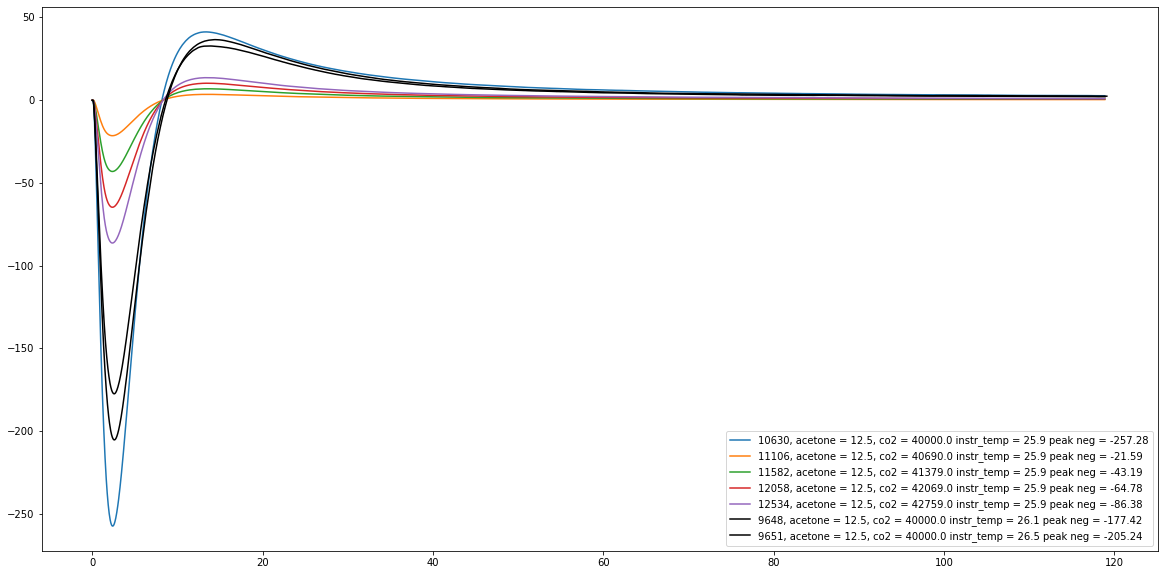

In [10]:
plt.figure(figsize=(20,10))
for filenum in test_list[:5]:
  instr_temp = fake_test_db_df.loc[filenum, 'Instr_Temp']
  ac_val = fake_test_db_df.loc[filenum, 'Acetone']
  co2_val = fake_test_db_df.loc[filenum, 'CO2']
  peak_neg = fake_test_db_df.loc[filenum, 'Peak_neg']
  test_data = pd.read_csv(fakes_path + '/test_output' + str(int(filenum)) + '.csv')
  plt.plot(test_data['Second'], test_data['mV_rolling_mean'], label = str(filenum) + ', acetone = ' + str(round(ac_val, 3)) + ', co2 = ' + str(round(co2_val, 0)) + ' instr_temp = ' + str(round(instr_temp,1)) + ' peak neg = ' + str(round(peak_neg,2)))
for filenum in real_test_list:
  instr_temp = fake_test_db_df.loc[filenum, 'Instr_Temp']
  ac_val = fake_test_db_df.loc[filenum, 'Acetone']
  co2_val = fake_test_db_df.loc[filenum, 'CO2']
  peak_neg = fake_test_db_df.loc[filenum, 'Peak_neg']
  path_1 = fakes_path + '/test_output''test_output' + str(int(filenum)) + '.csv'
  path_2 = '/content/drive/My Drive/Test_outputs/General/test_output' + str(int(filenum)) + '.csv'
  if os.path.exists(path_1):
    test_data = pd.read_csv(path_1)
  else:
    test_data = pd.read_csv(path_2)
  plt.plot(test_data['Second'], test_data['mV_rolling_mean'], label = str(filenum) + ', acetone = ' + str(round(ac_val, 3)) + ', co2 = ' + str(round(co2_val, 0)) + ' instr_temp = ' + str(round(instr_temp,1)) + ' peak neg = ' + str(round(peak_neg,2)), c= 'k')
plt.plot()
plt.legend()
plt.show()

# Show Stats

In [13]:
def get_stats (tests):
    
    test_group = fake_test_db_df.loc[tests, : ]
    stats = pd.DataFrame(columns=['Baseline','Peak_neg','Peak_pos','Peak_neg_t','Cross_t','Peak_pos_t'])
    stats.loc['Min', 'Baseline'] = test_group['Baseline'].min()
    stats.loc['Max', 'Baseline'] = test_group['Baseline'].max()
    stats.loc['Min', 'Peak_neg'] = test_group['Peak_neg'].min()
    stats.loc['Max', 'Peak_neg'] = test_group['Peak_neg'].max()
    stats.loc['Min', 'Peak_pos'] = test_group['Peak_pos'].min()
    stats.loc['Max', 'Peak_pos'] = test_group['Peak_pos'].max()
    stats.loc['Min', 'Peak_neg_t'] = test_group['Peak_neg_t'].min()
    stats.loc['Max', 'Peak_neg_t'] = test_group['Peak_neg_t'].max()
    stats.loc['Min', 'Cross_t'] = test_group['Cross_t'].min()
    stats.loc['Max', 'Cross_t'] = test_group['Cross_t'].max()
    stats.loc['Min', 'Peak_pos_t'] = test_group['Peak_pos_t'].min()
    stats.loc['Max', 'Peak_pos_t'] = test_group['Peak_pos_t'].max()
    print(stats.head())
    return()


In [15]:
get_stats(get_test_list (fake_test_db_df, 'all', 'all', 10, 19, 10000, 50000))

    Baseline  Peak_neg   Peak_pos Peak_neg_t Cross_t Peak_pos_t
Min  131.017  -2154.97  0.0258307      1.924   7.008     11.776
Max  145.115 -0.195565    383.594      2.728    9.94       15.4


()

In [111]:
bad1_a1 =  fake_test_db_df.loc[10000, 'Peak_neg']
bad1_a2 =  fake_test_db_df.loc[10030, 'Peak_neg']

print(bad1_a1)
print(bad1_a2)

-18.960522449774405
-18.16372595079435


In [32]:
fake_test_db_df.head()

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old,Tests,File_num
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9600,pdata9600,4% CO2 through plain water,10.0,40000.0,0.4,0.0000,0.0,0.0,1.0,19.0,2020-08-12,4:52:10,100000.0,1.0,40.21,0.0,26.97,26.70,4.29,0.0,NaN,250.0,29739.0,138.590360,140.299732,1.7094,-201.494212,2.564,641.0,9.720,2430.0,21.255789,15.180,3795.0,0.0,0.0,-964.480165,0.0,0.0,531.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9600.0,0.0
9603,pdata9603,4% CO2 through plain water,10.0,40000.0,0.8,0.0000,0.0,0.0,1.0,19.0,2020-08-12,5:02:22,612.0,2.0,41.68,0.0,26.38,26.17,4.38,0.0,NaN,250.0,29762.0,138.598053,139.051119,0.4531,-214.762738,2.588,647.0,9.784,2446.0,22.320042,15.192,3798.0,0.0,0.0,-1031.707572,0.0,0.0,553.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9603.0,0.0
9606,pdata9606,6% CO2 through plain water,10.0,60000.0,1.4,0.0000,0.0,0.0,1.0,19.0,2020-08-12,5:11:17,535.0,3.0,43.80,0.0,25.74,25.51,4.29,0.0,NaN,250.0,29775.0,138.543365,139.034170,0.4908,-319.336814,2.584,646.0,9.896,2474.0,32.715501,15.228,3807.0,0.0,0.0,-1551.996551,0.0,0.0,863.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9606.0,0.0
9609,pdata9609,6% CO2 through plain water,10.0,60000.0,2.0,0.0000,0.0,0.0,1.0,19.0,2020-08-12,5:20:20,543.0,4.0,43.88,0.0,25.39,25.10,4.24,0.0,NaN,250.0,29766.0,138.240113,138.832362,0.5922,-321.963345,2.616,654.0,9.956,2489.0,33.050086,15.388,3847.0,0.0,0.0,-1574.392437,0.0,0.0,854.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9609.0,0.0
9612,pdata9612,4% CO2 through 1.5625 ppm acetone simulator,10.0,40000.0,2.4,1.5625,0.0,0.0,1.0,19.0,2020-08-12,5:52:40,1940.0,5.0,40.49,0.0,26.04,25.87,4.27,0.0,NaN,250.0,29744.0,138.525839,138.691733,0.1659,-175.652029,2.588,647.0,9.692,2423.0,19.664613,15.152,3788.0,0.0,0.0,-843.821572,0.0,0.0,436.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9612.0,0.0


In [30]:
make_db_from_get_test_list (fake_test_db_df, 'all', 'all', 10, 19, 9700, 1000000)

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old,Tests,File_num
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9702,pdata9702,6% CO2 through 3.125 ppm acetone simulator,10.0,60000.000000,17.400000,3.125000,0.0,0.0,1.0,19.0,2020-08-13,4:41:20,526.000000,35.000000,61.68,0.0,17.230000,16.7391,2.97773,0.0,NaN,250.0,29781.0,133.101148,134.020657,0.9195,-296.612038,2.736,684.0,9.860,2465.0,33.706601,15.304,3826.0,0.0,0.0,-1465.582882,0.0,0.0,964.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9702,0.0
9705,pdata9705,6% CO2 through 3.125 ppm acetone simulator,10.0,60000.000000,18.000000,3.125000,0.0,0.0,1.0,19.0,2020-08-13,4:50:32,552.000000,36.000000,65.96,0.0,17.050000,16.6426,2.88750,0.0,NaN,250.0,29780.0,132.289574,133.879086,1.5895,-343.017235,2.688,672.0,9.868,2467.0,40.482247,15.412,3853.0,0.0,0.0,-1704.677128,0.0,0.0,1251.94,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9705,0.0
9708,pdata9708,4% CO2 through 6.25 ppm acetone simulator,10.0,40000.000000,18.400000,6.250000,0.0,0.0,1.0,19.0,2020-08-13,5:11:34,1262.000000,37.000000,62.52,0.0,16.560000,16.3423,2.69414,0.0,NaN,250.0,29748.0,132.420987,133.315133,0.8941,-201.215795,2.716,679.0,9.504,2376.0,27.394500,15.200,3800.0,0.0,0.0,-977.597592,0.0,0.0,762.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9708,0.0
9711,pdata9711,4% CO2 through 6.25 ppm acetone simulator,10.0,40000.000000,18.800000,6.250000,0.0,0.0,1.0,19.0,2020-08-13,5:20:24,530.000000,38.000000,62.80,0.0,16.490000,16.3101,2.82305,0.0,NaN,250.0,29778.0,133.115054,133.675954,0.5609,-228.470539,2.744,686.0,9.616,2404.0,29.673581,15.316,3829.0,0.0,0.0,-1116.950909,0.0,0.0,806.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9711,0.0
9714,pdata9714,6% CO2 through 6.25 ppm acetone simulator,10.0,60000.000000,19.400000,6.250000,0.0,0.0,1.0,19.0,2020-08-13,5:29:27,543.000000,39.000000,65.95,0.0,16.560000,16.3745,2.83594,0.0,NaN,250.0,29777.0,132.807017,133.752142,0.9451,-287.571045,2.740,685.0,9.728,2432.0,36.546263,15.132,3783.0,0.0,0.0,-1417.858501,0.0,0.0,1020.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9714,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15175,NaN,Combo of 14934 and 14948 | Weight - 0.82758620...,10.0,46896.551724,26.746730,5.833333,0.0,NaN,1.0,19.0,NaN,NaN,586.116132,53.781768,0.00,0.0,31.837103,0.0000,0.00000,0.0,NaN,250.0,29720.0,142.314946,143.348874,0.0000,-319.962289,2.200